In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import random

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Define class names
class_names = [
    "Unlabeled", "Building", "Fence", "Other", "Pedestrian", "Pole",
    "Roadline", "Road", "Sidewalk", "Vegetation", "Car", "Wall", "Traffic sign"
]
num_classes = len(class_names)

# Define paths for Kaggle
dataset_path = "/kaggle/input/q2-unet/dataset_256"
train_images_path = os.path.join(dataset_path, "train", "images")
train_labels_path = os.path.join(dataset_path, "train", "labels")
test_images_path = os.path.join(dataset_path, "test", "images")
test_labels_path = os.path.join(dataset_path, "test", "labels")

# Define model components
class DoubleConv(nn.Module):
    """(Conv => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# Attention Gate as shown in figure3.jpg
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        """
        Attention Gate as described in the paper
        
        Args:
            F_g (int): Number of channels in gating signal (from coarser scale)
            F_l (int): Number of channels in input feature map (skip connection)
            F_int (int): Number of intermediate channels
        """
        super(AttentionGate, self).__init__()
        
        # 1x1 convolution for gating signal (g)
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        # 1x1 convolution for input feature map (x)
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        # 1x1 convolution for attention coefficients
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        # Apply 1x1 convolutions
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        # Ensure g1 has the same spatial dimensions as x1
        if g1.size()[2:] != x1.size()[2:]:
            g1 = F.interpolate(g1, size=x1.size()[2:], mode='bilinear', align_corners=True)
        
        # Addition followed by ReLU
        psi = self.relu(g1 + x1)
        
        # Apply 1x1 convolution and sigmoid to get attention coefficients
        psi = self.psi(psi)
        
        # Using α = 1 as specified in the question
        # Multiply input feature map with attention coefficients (element-wise)
        out = x * psi
        
        return out

# Upsampling with Attention Gate for skip connections
class AttentionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionUp, self).__init__()
        
        # Use transposed convolution for upsampling as in vanilla U-Net
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        
        # Attention Gate
        self.attention_gate = AttentionGate(
            F_g=in_channels // 2,  # Gating signal channels (from upsampled features)
            F_l=out_channels,      # Skip connection channels
            F_int=out_channels // 2 # Intermediate channels
        )
        
        # Convolution after concatenation
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 is from the decoder path (deeper layer)
        # x2 is from the encoder path (skip connection)
        
        # Upsample x1
        x1 = self.up(x1)
        
        # Ensure x1 has the same size as x2
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, 
                         diffY // 2, diffY - diffY // 2])
        
        # Apply attention gate - x1 is the gating signal, x2 is the skip connection
        x2_att = self.attention_gate(x1, x2)
        
        # Concatenate upsampled x1 with attention-gated x2
        x = torch.cat([x2_att, x1], dim=1)
        
        # Apply convolution
        return self.conv(x)

# Attention U-Net model
class AttentionUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(AttentionUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # Encoder path (contracting)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        
        # Bottleneck
        self.down4 = Down(512, 1024)
        
        # Decoder path with attention gates at skip connections
        self.up1 = AttentionUp(1024, 512)
        self.up2 = AttentionUp(512, 256)
        self.up3 = AttentionUp(256, 128)
        self.up4 = AttentionUp(128, 64)
        
        # Final convolution
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        # Bottleneck
        x5 = self.down4(x4)
        
        # Decoder path with attention-gated skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # Final layer
        logits = self.outc(x)
        return logits

# Dataset class
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted(os.listdir(images_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name)
        
        # Load image and mask
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))
        
        # Extract class IDs from mask
        if len(mask.shape) > 2:
            mask = mask[:, :, 0]  # Take first channel if multiple channels
        
        # Convert to tensors and normalize image
        if self.transform:
            # Apply transformations if provided
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        else:
            # Basic transformation
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.0
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask).long()  # Ensure mask is Long type
        
        return image, mask

# Calculate Mean IoU
def calculate_miou(pred, target, num_classes):
    iou_list = []
    pred = pred.argmax(dim=1).view(-1)
    target = target.view(-1)
    
    # Calculate IoU for each class
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            iou = 1.0  # If there's no ground truth and no prediction, consider it perfect
        else:
            iou = intersection / union
        
        iou_list.append(iou)
    
    return np.mean(iou_list)

# Function to visualize predictions
def visualize_prediction(image, mask, pred, idx, prefix="attention"):
    """
    Visualize the image, ground truth mask and prediction side by side
    """
    # Create a colormap for the segmentation masks
    colors = plt.cm.tab20(np.linspace(0, 1, num_classes))
    custom_cmap = ListedColormap(colors)
    
    # Convert tensors to numpy arrays
    if torch.is_tensor(image):
        image = image.cpu().numpy().transpose(1, 2, 0)  # Convert from CxHxW to HxWxC
        
    if torch.is_tensor(mask):
        mask = mask.cpu().numpy()
        
    if torch.is_tensor(pred):
        pred = pred.argmax(dim=0).cpu().numpy()
    
    # Denormalize image if it was normalized using ImageNet mean/std
    if image.min() < 0 or image.max() <= 1.0:
        # Check if image is normalized with ImageNet stats
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        # Denormalize
        image = image * std + mean
        image = np.clip(image, 0, 1)
        image = (image * 255).astype(np.uint8)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original image
    axes[0].imshow(image)
    axes[0].set_title("Input Image")
    axes[0].axis('off')
    
    # Plot ground truth mask
    axes[1].imshow(custom_cmap(mask))
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')
    
    # Plot prediction
    axes[2].imshow(custom_cmap(pred))
    axes[2].set_title("Prediction (Attention U-Net)")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"/kaggle/working/{prefix}_prediction_{idx}.png")
    plt.close()

# Train function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cuda'):
    model.to(device)
    best_miou = 0.0
    
    # Track metrics
    train_losses = []
    val_losses = []
    train_mious = []
    val_mious = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_miou = 0.0
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        progress_bar = tqdm(train_loader, desc="Training")
        
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Ensure masks are in long format for CrossEntropyLoss
            masks = masks.long()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            train_loss += loss.item() * images.size(0)
            train_miou += calculate_miou(outputs, masks, num_classes) * images.size(0)
            
            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())
        
        train_loss = train_loss / len(train_loader.dataset)
        train_miou = train_miou / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_mious.append(train_miou)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_miou = 0.0
        
        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc="Validation")
            
            for images, masks in progress_bar:
                images = images.to(device)
                masks = masks.to(device)
                
                # Ensure masks are in long format for CrossEntropyLoss
                masks = masks.long()
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item() * images.size(0)
                val_miou += calculate_miou(outputs, masks, num_classes) * images.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_miou = val_miou / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_mious.append(val_miou)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train mIoU: {train_miou:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val mIoU: {val_miou:.4f}")
        
        # Save model if validation mIoU improved
        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(model.state_dict(), '/kaggle/working/best_attention_unet_model.pth')
            print(f"Model saved with validation mIoU: {val_miou:.4f}")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves (Attention U-Net)')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_mious, label='Train mIoU')
    plt.plot(val_mious, label='Val mIoU')
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.legend()
    plt.title('mIoU Curves (Attention U-Net)')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_curves_attention.png')
    plt.show()
    
    return train_losses, val_losses, train_mious, val_mious

# Test model and visualize predictions
def test_model(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()
    
    test_miou = 0.0
    samples_to_visualize = 5
    visualized = 0
    
    with torch.no_grad():
        for idx, (images, masks) in enumerate(tqdm(test_loader, desc="Testing")):
            images = images.to(device)
            masks = masks.to(device)
            
            # Ensure masks are in long format for CrossEntropyLoss
            masks = masks.long()
            
            outputs = model(images)
            
            # Calculate mIoU
            batch_miou = calculate_miou(outputs, masks, num_classes)
            test_miou += batch_miou * images.size(0)
            
            # Visualize a few predictions
            if visualized < samples_to_visualize:
                for i in range(min(images.size(0), samples_to_visualize - visualized)):
                    visualize_prediction(
                        images[i].cpu(), 
                        masks[i].cpu(), 
                        outputs[i].cpu(), 
                        visualized,
                        prefix="attention"
                    )
                    visualized += 1
                    if visualized >= samples_to_visualize:
                        break
    
    test_miou = test_miou / len(test_loader.dataset)
    print(f"Test mIoU: {test_miou:.4f}")
    
    return test_miou


Using device: cuda


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using albumentations library for transformations
Training dataset size: 1600
Validation dataset size: 400
Test dataset size: 500
Number of trainable parameters: 31395833
Starting model training for Attention U-Net...
Epoch 1/50


Validation: 100%|██████████| 50/50 [00:05<00:00,  9.97it/s]


Epoch 1/50, Train Loss: 0.6382, Train mIoU: 0.3711, Val Loss: 0.3977, Val mIoU: 0.4389
Model saved with validation mIoU: 0.4389
Epoch 2/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.12it/s]


Epoch 2/50, Train Loss: 0.2880, Train mIoU: 0.4883, Val Loss: 0.3884, Val mIoU: 0.4707
Model saved with validation mIoU: 0.4707
Epoch 3/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.13it/s]


Epoch 3/50, Train Loss: 0.2292, Train mIoU: 0.5302, Val Loss: 0.2144, Val mIoU: 0.5593
Model saved with validation mIoU: 0.5593
Epoch 4/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.14it/s]


Epoch 4/50, Train Loss: 0.1962, Train mIoU: 0.5656, Val Loss: 0.2058, Val mIoU: 0.5700
Model saved with validation mIoU: 0.5700
Epoch 5/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.10it/s]


Epoch 5/50, Train Loss: 0.1630, Train mIoU: 0.5991, Val Loss: 0.1940, Val mIoU: 0.5955
Model saved with validation mIoU: 0.5955
Epoch 6/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.18it/s]


Epoch 6/50, Train Loss: 0.1516, Train mIoU: 0.6180, Val Loss: 0.1516, Val mIoU: 0.6308
Model saved with validation mIoU: 0.6308
Epoch 7/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.19it/s]


Epoch 7/50, Train Loss: 0.1319, Train mIoU: 0.6444, Val Loss: 0.1457, Val mIoU: 0.6442
Model saved with validation mIoU: 0.6442
Epoch 8/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.20it/s]


Epoch 8/50, Train Loss: 0.1296, Train mIoU: 0.6571, Val Loss: 0.6831, Val mIoU: 0.4243
Epoch 9/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.20it/s]


Epoch 9/50, Train Loss: 0.1536, Train mIoU: 0.6300, Val Loss: 0.1271, Val mIoU: 0.6603
Model saved with validation mIoU: 0.6603
Epoch 10/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.19it/s]


Epoch 10/50, Train Loss: 0.1066, Train mIoU: 0.6876, Val Loss: 0.1073, Val mIoU: 0.6980
Model saved with validation mIoU: 0.6980
Epoch 11/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.06it/s]


Epoch 11/50, Train Loss: 0.0998, Train mIoU: 0.6980, Val Loss: 0.1054, Val mIoU: 0.7079
Model saved with validation mIoU: 0.7079
Epoch 12/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.12it/s]


Epoch 12/50, Train Loss: 0.0930, Train mIoU: 0.7117, Val Loss: 0.0889, Val mIoU: 0.7269
Model saved with validation mIoU: 0.7269
Epoch 13/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.12it/s]


Epoch 13/50, Train Loss: 0.0907, Train mIoU: 0.7198, Val Loss: 0.0950, Val mIoU: 0.7290
Model saved with validation mIoU: 0.7290
Epoch 14/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.13it/s]


Epoch 14/50, Train Loss: 0.0804, Train mIoU: 0.7398, Val Loss: 0.0984, Val mIoU: 0.7250
Epoch 15/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.11it/s]


Epoch 15/50, Train Loss: 0.0777, Train mIoU: 0.7468, Val Loss: 0.1188, Val mIoU: 0.6932
Epoch 16/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.12it/s]


Epoch 16/50, Train Loss: 0.0743, Train mIoU: 0.7515, Val Loss: 0.0762, Val mIoU: 0.7627
Model saved with validation mIoU: 0.7627
Epoch 17/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.11it/s]


Epoch 17/50, Train Loss: 0.0666, Train mIoU: 0.7713, Val Loss: 0.0754, Val mIoU: 0.7584
Epoch 18/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.19it/s]


Epoch 18/50, Train Loss: 0.0720, Train mIoU: 0.7591, Val Loss: 0.0868, Val mIoU: 0.7507
Epoch 19/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.20it/s]


Epoch 19/50, Train Loss: 0.0631, Train mIoU: 0.7773, Val Loss: 0.0682, Val mIoU: 0.7711
Model saved with validation mIoU: 0.7711
Epoch 20/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.19it/s]


Epoch 20/50, Train Loss: 0.0569, Train mIoU: 0.7907, Val Loss: 0.0645, Val mIoU: 0.7907
Model saved with validation mIoU: 0.7907
Epoch 21/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.17it/s]


Epoch 21/50, Train Loss: 0.0549, Train mIoU: 0.7959, Val Loss: 0.0694, Val mIoU: 0.7916
Model saved with validation mIoU: 0.7916
Epoch 22/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.17it/s]


Epoch 22/50, Train Loss: 0.0525, Train mIoU: 0.8033, Val Loss: 0.0583, Val mIoU: 0.8042
Model saved with validation mIoU: 0.8042
Epoch 23/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.15it/s]


Epoch 23/50, Train Loss: 0.0519, Train mIoU: 0.8042, Val Loss: 0.0805, Val mIoU: 0.7702
Epoch 24/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.16it/s]


Epoch 24/50, Train Loss: 0.0783, Train mIoU: 0.7527, Val Loss: 0.0763, Val mIoU: 0.7631
Epoch 25/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.13it/s]


Epoch 25/50, Train Loss: 0.0485, Train mIoU: 0.8110, Val Loss: 0.0527, Val mIoU: 0.8176
Model saved with validation mIoU: 0.8176
Epoch 26/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.04it/s]


Epoch 26/50, Train Loss: 0.0450, Train mIoU: 0.8240, Val Loss: 0.0530, Val mIoU: 0.8188
Model saved with validation mIoU: 0.8188
Epoch 27/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.14it/s]


Epoch 27/50, Train Loss: 0.0423, Train mIoU: 0.8266, Val Loss: 0.0531, Val mIoU: 0.8187
Epoch 28/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.13it/s]


Epoch 28/50, Train Loss: 0.0404, Train mIoU: 0.8359, Val Loss: 0.0607, Val mIoU: 0.7961
Epoch 29/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.12it/s]


Epoch 29/50, Train Loss: 0.0419, Train mIoU: 0.8295, Val Loss: 0.0578, Val mIoU: 0.8186
Epoch 30/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.08it/s]


Epoch 30/50, Train Loss: 0.0404, Train mIoU: 0.8319, Val Loss: 0.0492, Val mIoU: 0.8296
Model saved with validation mIoU: 0.8296
Epoch 31/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.14it/s]


Epoch 31/50, Train Loss: 0.0385, Train mIoU: 0.8393, Val Loss: 0.0497, Val mIoU: 0.8304
Model saved with validation mIoU: 0.8304
Epoch 32/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.10it/s]


Epoch 32/50, Train Loss: 0.0351, Train mIoU: 0.8476, Val Loss: 0.0480, Val mIoU: 0.8375
Model saved with validation mIoU: 0.8375
Epoch 33/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.10it/s]


Epoch 33/50, Train Loss: 0.0376, Train mIoU: 0.8419, Val Loss: 0.0472, Val mIoU: 0.8303
Epoch 34/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.09it/s]


Epoch 34/50, Train Loss: 0.0349, Train mIoU: 0.8520, Val Loss: 0.0430, Val mIoU: 0.8422
Model saved with validation mIoU: 0.8422
Epoch 35/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.10it/s]


Epoch 35/50, Train Loss: 0.0340, Train mIoU: 0.8496, Val Loss: 0.0486, Val mIoU: 0.8333
Epoch 36/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.15it/s]


Epoch 36/50, Train Loss: 0.1087, Train mIoU: 0.7340, Val Loss: 0.1353, Val mIoU: 0.6838
Epoch 37/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.11it/s]


Epoch 37/50, Train Loss: 0.0675, Train mIoU: 0.7692, Val Loss: 0.0587, Val mIoU: 0.8086
Epoch 38/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.11it/s]


Epoch 38/50, Train Loss: 0.0417, Train mIoU: 0.8318, Val Loss: 0.0488, Val mIoU: 0.8316
Epoch 39/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.11it/s]


Epoch 39/50, Train Loss: 0.0352, Train mIoU: 0.8532, Val Loss: 0.0453, Val mIoU: 0.8364
Epoch 40/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.09it/s]


Epoch 40/50, Train Loss: 0.0331, Train mIoU: 0.8521, Val Loss: 0.0425, Val mIoU: 0.8437
Model saved with validation mIoU: 0.8437
Epoch 41/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.14it/s]


Epoch 41/50, Train Loss: 0.0310, Train mIoU: 0.8580, Val Loss: 0.0404, Val mIoU: 0.8470
Model saved with validation mIoU: 0.8470
Epoch 42/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.19it/s]


Epoch 42/50, Train Loss: 0.0297, Train mIoU: 0.8642, Val Loss: 0.0416, Val mIoU: 0.8472
Model saved with validation mIoU: 0.8472
Epoch 43/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.17it/s]


Epoch 43/50, Train Loss: 0.0294, Train mIoU: 0.8640, Val Loss: 0.0402, Val mIoU: 0.8533
Model saved with validation mIoU: 0.8533
Epoch 44/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.19it/s]


Epoch 44/50, Train Loss: 0.0279, Train mIoU: 0.8686, Val Loss: 0.0407, Val mIoU: 0.8510
Epoch 45/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.17it/s]


Epoch 45/50, Train Loss: 0.0272, Train mIoU: 0.8705, Val Loss: 0.0400, Val mIoU: 0.8555
Model saved with validation mIoU: 0.8555
Epoch 46/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.11it/s]


Epoch 46/50, Train Loss: 0.0277, Train mIoU: 0.8736, Val Loss: 0.0439, Val mIoU: 0.8382
Epoch 47/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.15it/s]


Epoch 47/50, Train Loss: 0.0279, Train mIoU: 0.8701, Val Loss: 0.0408, Val mIoU: 0.8538
Epoch 48/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.15it/s]


Epoch 48/50, Train Loss: 0.0269, Train mIoU: 0.8685, Val Loss: 0.0390, Val mIoU: 0.8513
Epoch 49/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.19it/s]


Epoch 49/50, Train Loss: 0.0262, Train mIoU: 0.8748, Val Loss: 0.0405, Val mIoU: 0.8504
Epoch 50/50


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.22it/s]


Epoch 50/50, Train Loss: 0.0262, Train mIoU: 0.8720, Val Loss: 0.0377, Val mIoU: 0.8528


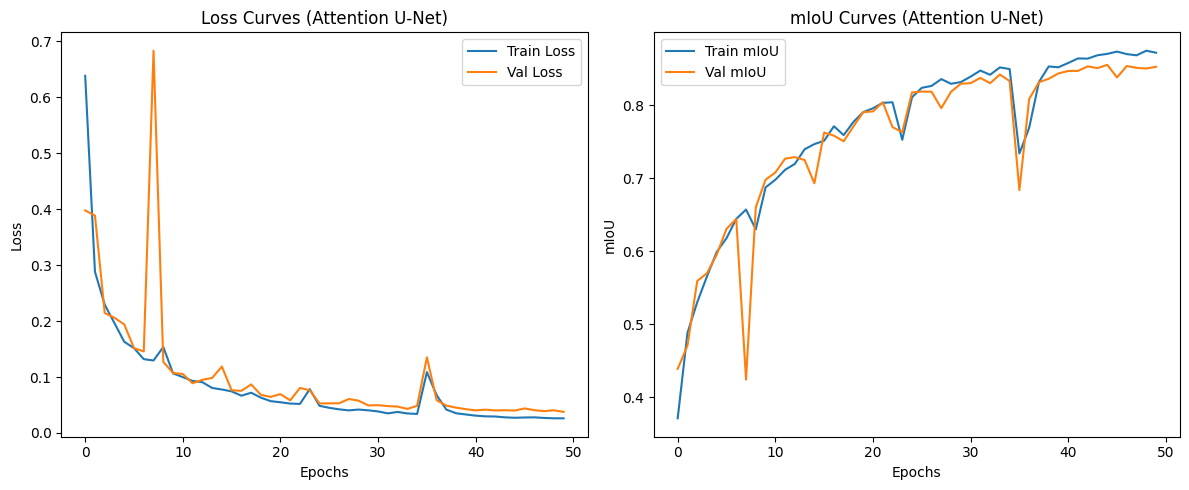

In [2]:

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Try to import albumentations if available, otherwise use basic transformations
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    
    train_transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    val_transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    # Create datasets with transforms
    train_dataset = SegmentationDataset(train_images_path, train_labels_path, transform=train_transform)
    
    # Split training data into train and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    test_dataset = SegmentationDataset(test_images_path, test_labels_path, transform=val_transform)
    
    print(f"Using albumentations library for transformations")
    
except ImportError:
    print("Albumentations not available, using basic transformations")
    
    # Basic dataset class without albumentations
    class BasicSegmentationDataset(Dataset):
        def __init__(self, images_dir, masks_dir):
            self.images_dir = images_dir
            self.masks_dir = masks_dir
            self.images = sorted(os.listdir(images_dir))
            
        def __len__(self):
            return len(self.images)
        
        def __getitem__(self, idx):
            img_name = self.images[idx]
            img_path = os.path.join(self.images_dir, img_name)
            mask_path = os.path.join(self.masks_dir, img_name)
            
            # Load image and mask
            image = np.array(Image.open(img_path).convert("RGB"))
            mask = np.array(Image.open(mask_path))
            
            # Extract class IDs from mask
            if len(mask.shape) > 2:
                mask = mask[:, :, 0]  # Take first channel if multiple channels
            
            # Basic transformation
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.0
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask).long()  # Explicitly convert to Long type
            
            return image, mask
    
    # Create datasets without special transforms
    train_dataset = BasicSegmentationDataset(train_images_path, train_labels_path)
    
    # Split training data into train and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    test_dataset = BasicSegmentationDataset(test_images_path, test_labels_path)

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create data loaders with proper batch size for Kaggle GPUs
batch_size = 8  # Lower batch size to avoid CUDA out of memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize the Attention U-Net model
model_attention = AttentionUNet(n_channels=3, n_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_attention.parameters(), lr=0.001)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model_attention)}")

# Train the model
print("Starting model training for Attention U-Net...")
train_losses, val_losses, train_mious, val_mious = train_model(
    model=model_attention,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,  
    device=device
)


<ipython-input-3-31db4c6bf719>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_attention.load_state_dict(torch.load('/kaggle/working/best_attention_unet_model.pth'))


Loading best model for testing...
Testing model on test dataset...


Testing: 100%|██████████| 63/63 [00:08<00:00,  7.14it/s]


Test mIoU: 0.8383
Final Test mIoU for Attention U-Net: 0.8383

Sample Predictions from Test Set (Attention U-Net):


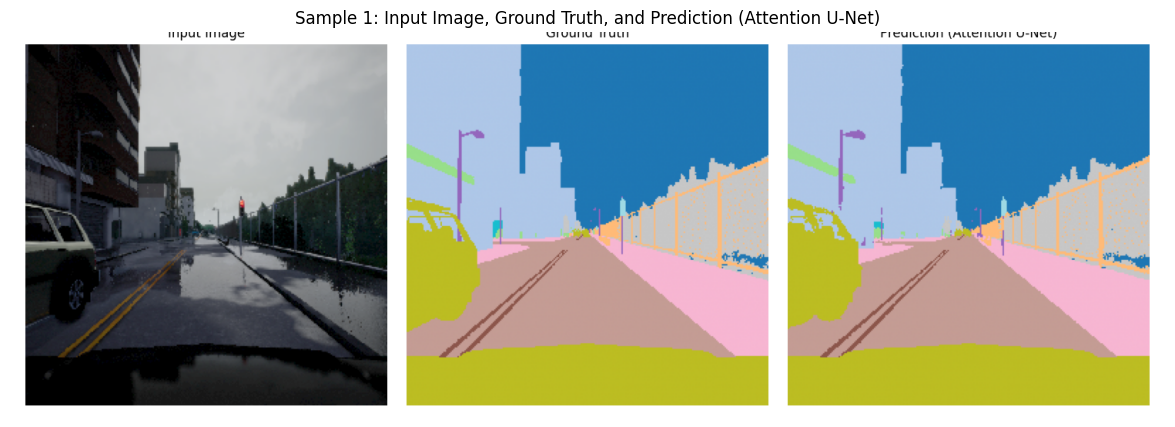

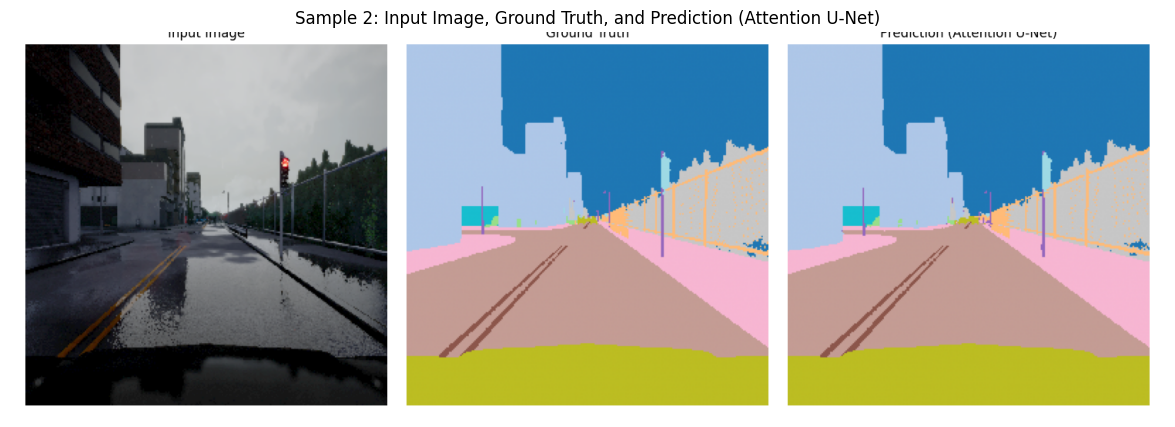

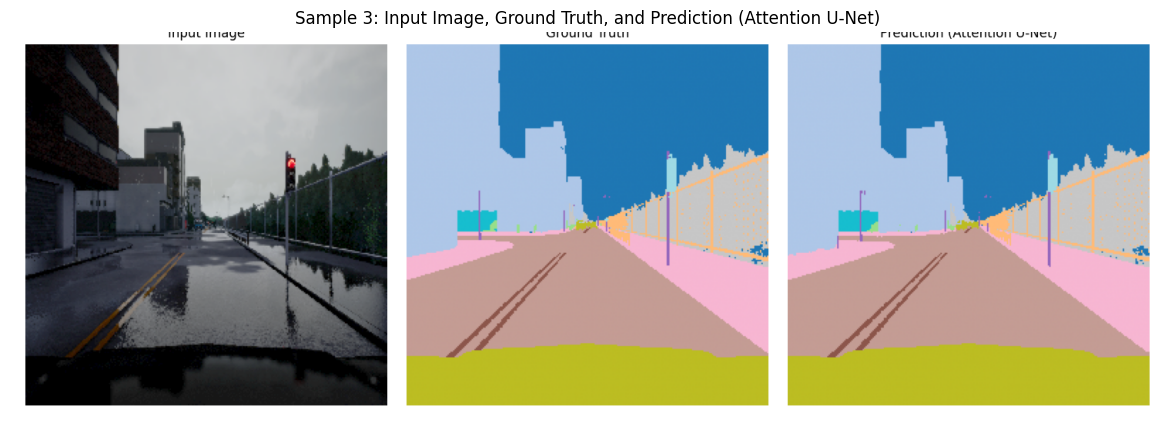

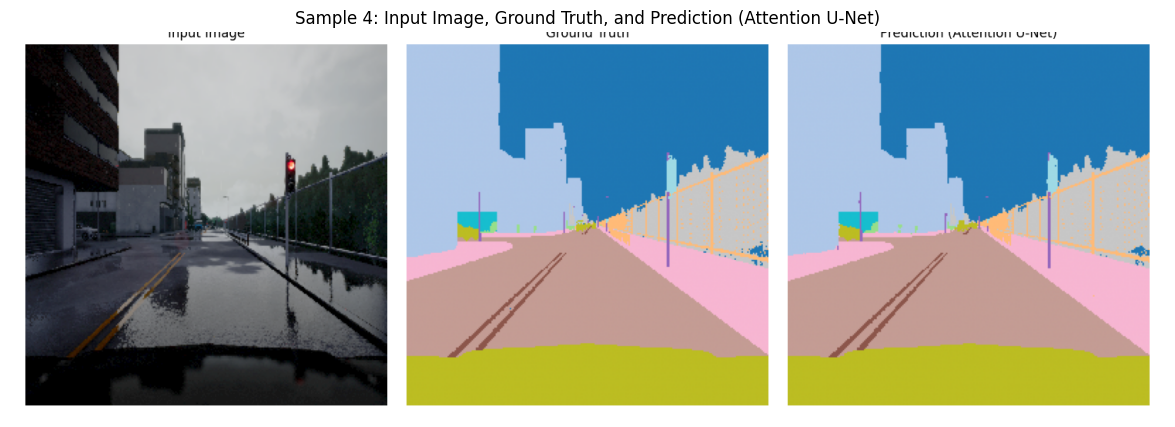

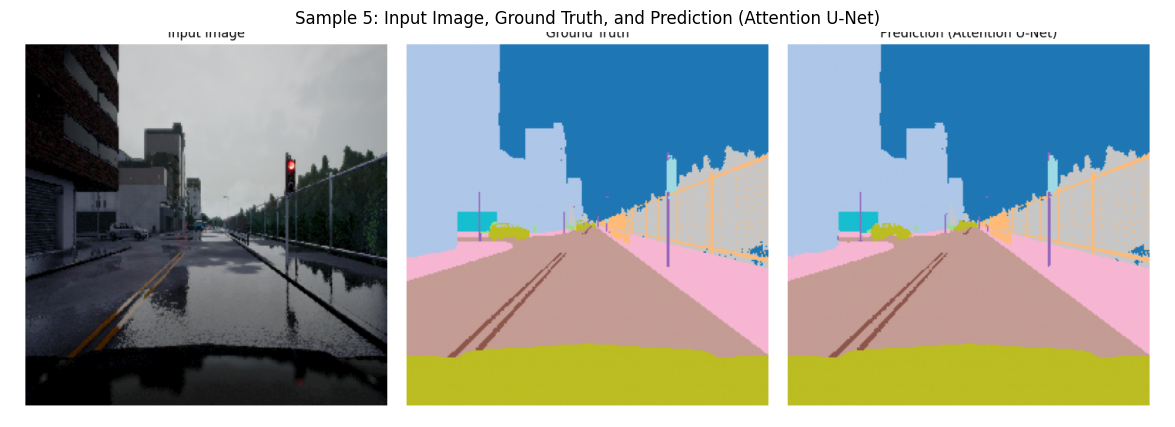

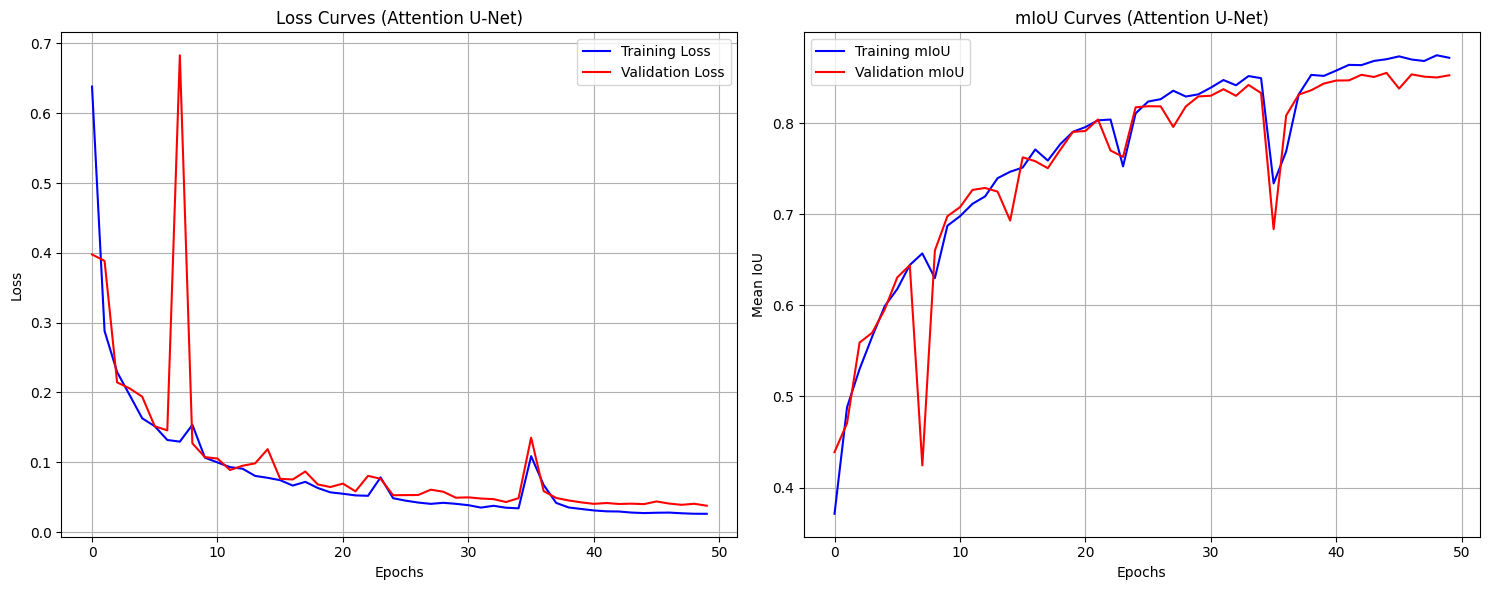

Best Training mIoU: 0.8748
Best Validation mIoU: 0.8555
Final Test mIoU: 0.8383


In [3]:

# Load best model for testing
print("Loading best model for testing...")
model_attention.load_state_dict(torch.load('/kaggle/working/best_attention_unet_model.pth'))

# Test the model
print("Testing model on test dataset...")
test_miou = test_model(model_attention, test_loader, device)
print(f"Final Test mIoU for Attention U-Net: {test_miou:.4f}")

# Display sample predictions
print("\nSample Predictions from Test Set (Attention U-Net):")
for i in range(5):
    vis_path = f'/kaggle/working/attention_prediction_{i}.png'
    if os.path.exists(vis_path):
        img = plt.imread(vis_path)
        plt.figure(figsize=(15, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Sample {i+1}: Input Image, Ground Truth, and Prediction (Attention U-Net)')
        plt.show()
    else:
        print(f"Warning: Visualization file {i} not found")

# Show training curves in more detail
plt.figure(figsize=(15, 6))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves (Attention U-Net)')
plt.legend()

# Plot mIoU curves
plt.subplot(1, 2, 2)
plt.plot(train_mious, 'b-', label='Training mIoU')
plt.plot(val_mious, 'r-', label='Validation mIoU')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.title('mIoU Curves (Attention U-Net)')
plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/detailed_training_curves_attention.png')
plt.show()

# Print the best mIoU values
best_train_miou = max(train_mious)
best_val_miou = max(val_mious)
print(f"Best Training mIoU: {best_train_miou:.4f}")
print(f"Best Validation mIoU: {best_val_miou:.4f}")
print(f"Final Test mIoU: {test_miou:.4f}")
